# READ DATA

In [3]:
# !pip install pandas
# !pip install openpyxl
# !pip install getFamaFrenchFactors
# !pip install pandas_datareader
# !pip install matplotlib scipy
# !pip install seaborn
# !pip install plotly
# !pip install nbformat
# # !pip install ipywidgets
# !pip install factor_analyzer

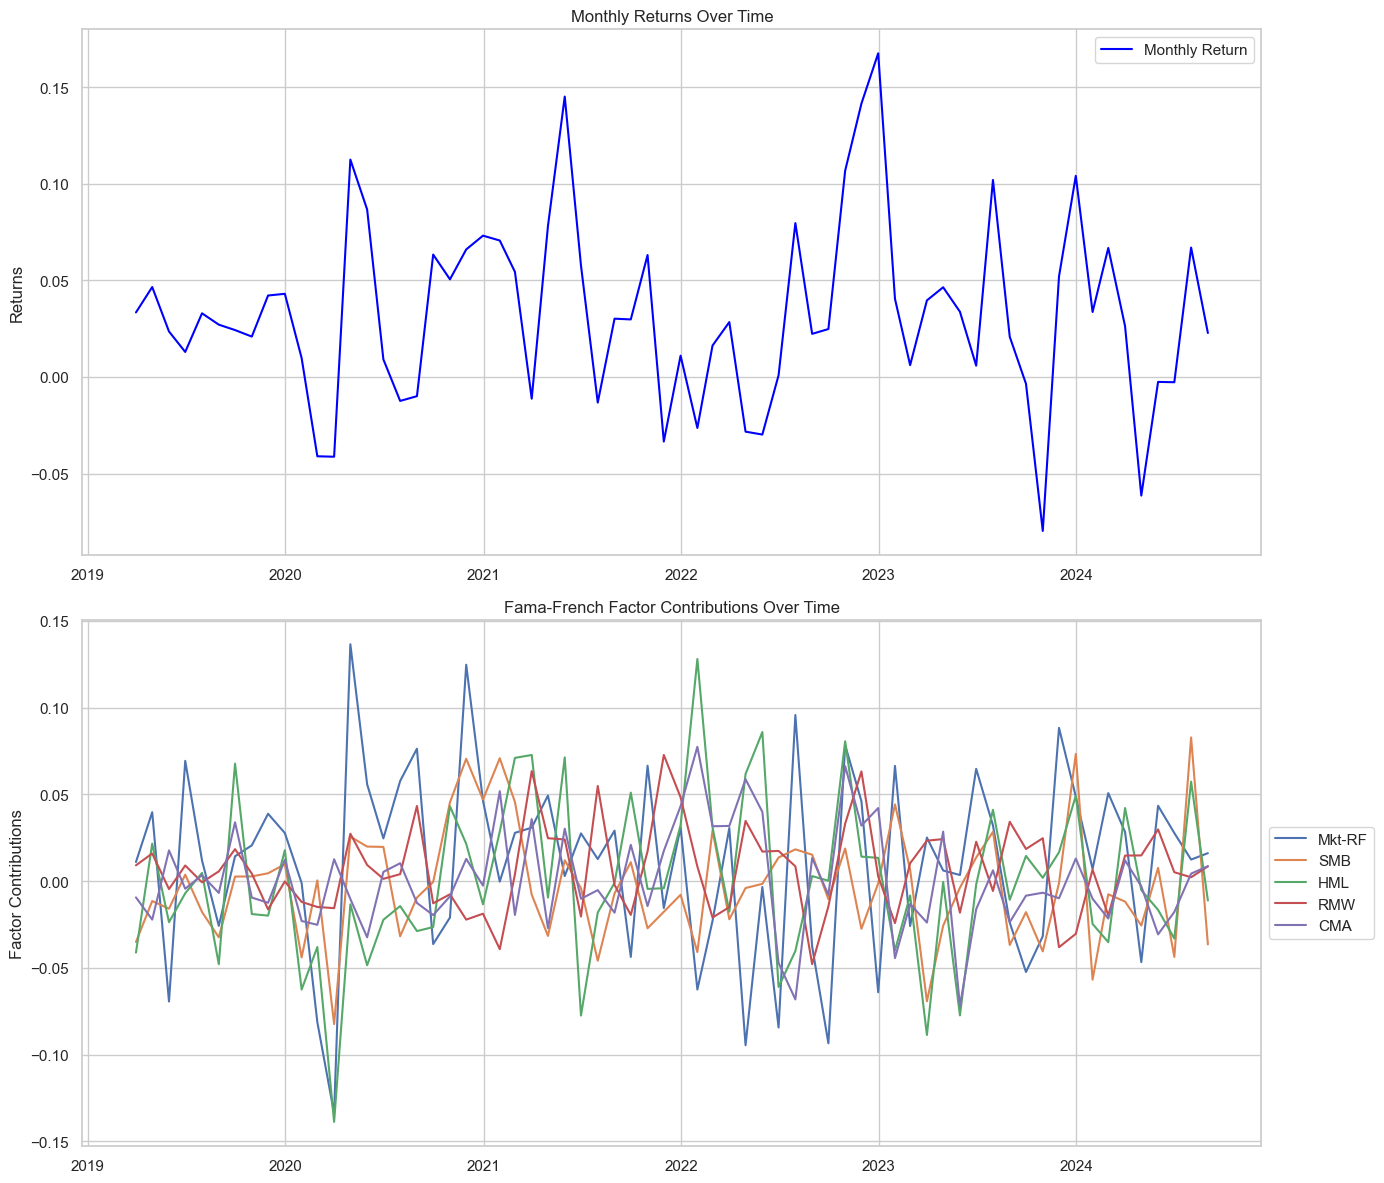

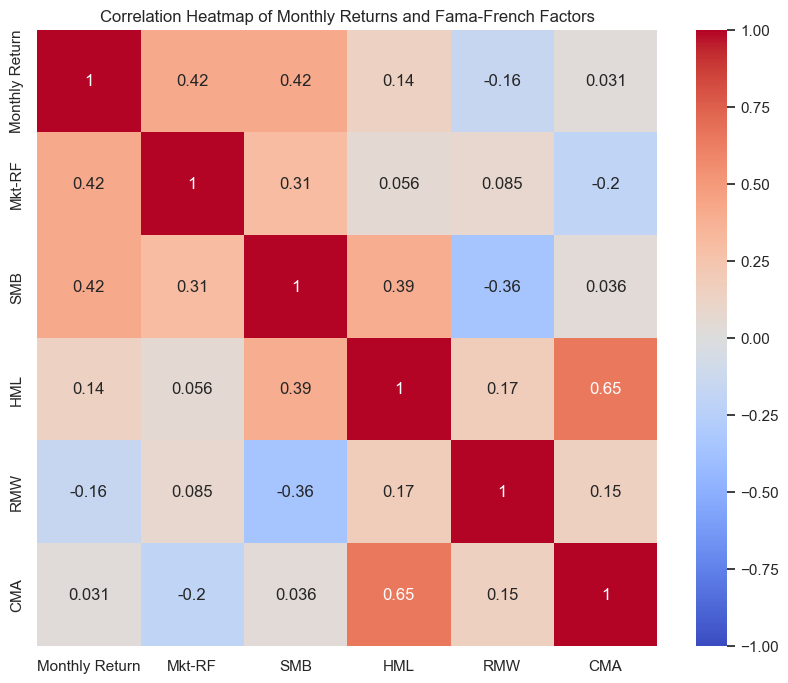

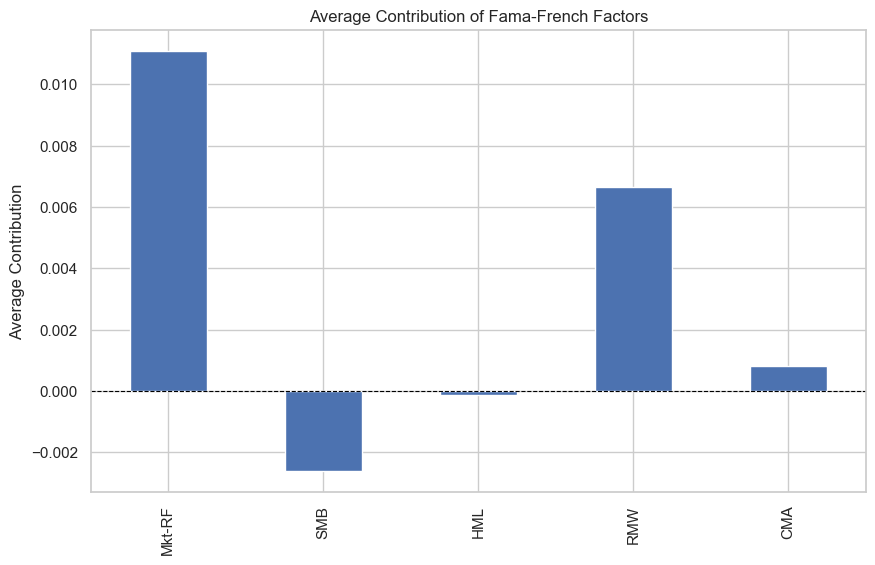

                            OLS Regression Results                            
Dep. Variable:         Monthly Return   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     4.908
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           0.000787
Time:                        08:42:56   Log-Likelihood:                 119.11
No. Observations:                  66   AIC:                            -226.2
Df Residuals:                      60   BIC:                            -213.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0313      0.005      5.750      0.0

<Figure size 1000x600 with 0 Axes>

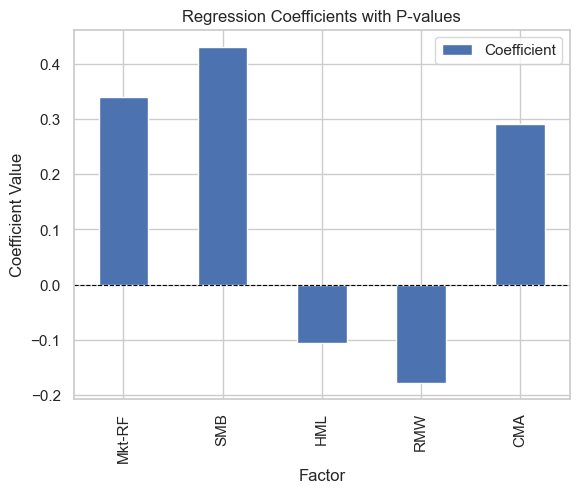

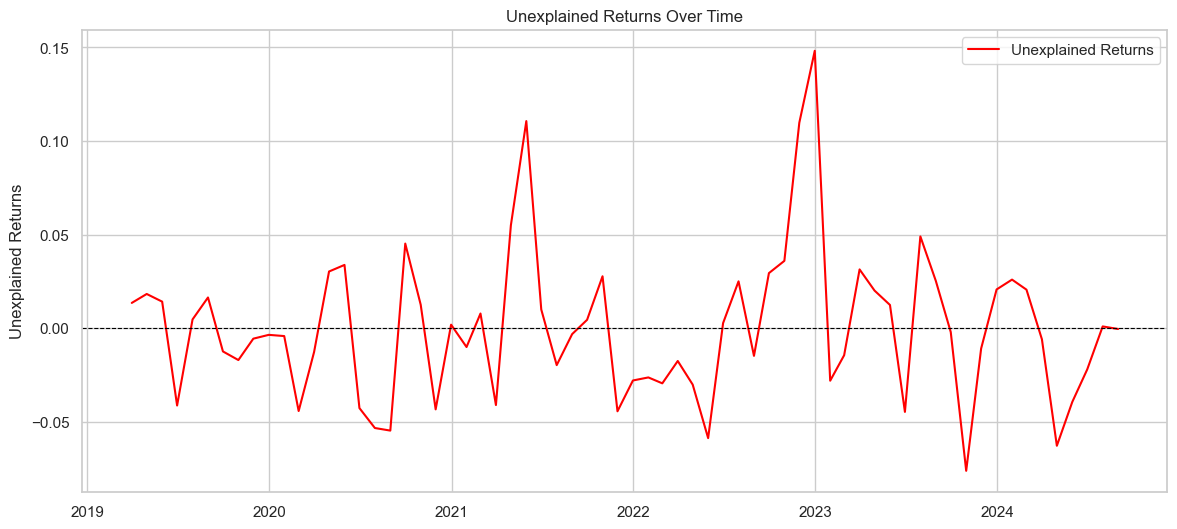


Factor Contributions:
Mkt-RF         3.760530e-03
SMB           -1.126366e-03
HML            1.438603e-05
RMW           -1.179819e-03
CMA            2.378479e-04
Unexplained   -5.771372e-16
dtype: float64


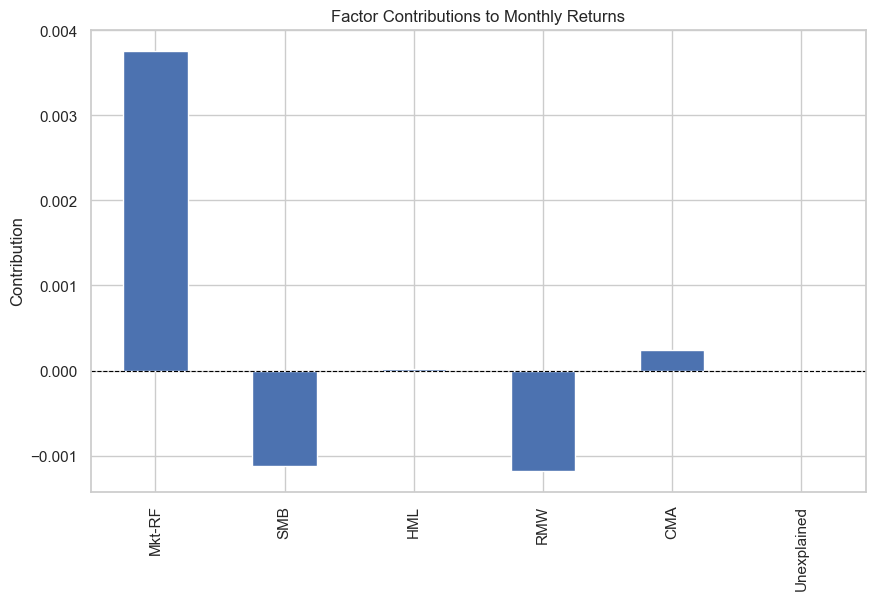

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import getFamaFrenchFactors as gff

# Set plot style for better aesthetics
sns.set(style="whitegrid")

# Step 1: Load and preprocess portfolio data
df_monthly_portfolio = pd.read_excel(r"C:\Users\MukeshwaranBaskaran\Downloads\Project_KISKI\Data\KISKI_Portfolio_Monthly.xlsx")
df_monthly_portfolio.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
df_monthly_portfolio.columns = df_monthly_portfolio.columns.str.strip()
df_monthly_portfolio['Date'] = pd.to_datetime(df_monthly_portfolio['Date'])

# Step 2: Load Fama-French 5 Factor data
df_ff5_monthly = gff.famaFrench5Factor(frequency='m')
df_ff5_monthly['date_ff_factors'] = pd.to_datetime(df_ff5_monthly['date_ff_factors'])

# Step 3: Merge portfolio and Fama-French data
df_monthly = pd.merge(
    df_monthly_portfolio,
    df_ff5_monthly,
    left_on='Date',
    right_on='date_ff_factors',
    how='inner'
)

# Step 4: Calculate monthly returns
df_monthly['Monthly Return'] = df_monthly['P&L (%)']

# Step 5: Set Date as Index
df_monthly.set_index('Date', inplace=True)

# Step 6: Plot Monthly Returns and Fama-French Factors
plt.figure(figsize=(14, 12))

# Plot Monthly Returns
plt.subplot(2, 1, 1)
plt.plot(df_monthly.index, df_monthly['Monthly Return'], label='Monthly Return', color='blue')
plt.title('Monthly Returns Over Time')
plt.ylabel('Returns')
plt.legend()

# Plot Fama-French Factors
plt.subplot(2, 1, 2)
for column in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']:
    plt.plot(df_monthly.index, df_monthly[column], label=column)
plt.title('Fama-French Factor Contributions Over Time')
plt.ylabel('Factor Contributions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Step 7: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_monthly[['Monthly Return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Monthly Returns and Fama-French Factors')
plt.show()

# Step 8: Factor Contribution Bar Chart
plt.figure(figsize=(10, 6))
df_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean().plot(kind='bar')
plt.title('Average Contribution of Fama-French Factors')
plt.ylabel('Average Contribution')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

# Step 9: Regression Analysis
X = sm.add_constant(df_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
y = df_monthly['Monthly Return']
model = sm.OLS(y, X).fit()

# Step 10: Calculate Unexplained Returns
df_monthly['Unexplained'] = y - model.predict(X)

# Print regression summary
print(model.summary())

# Step 11: Coefficient Plot
plt.figure(figsize=(10, 6))
coeff_df = pd.DataFrame({
    'Factor': model.params.index[1:], 
    'Coefficient': model.params.values[1:], 
    'P-Value': model.pvalues.values[1:]
})
coeff_df.set_index('Factor').plot(y='Coefficient', kind='bar', yerr=coeff_df['P-Value'], capsize=5)
plt.title('Regression Coefficients with P-values')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

# Step 12: Plot Unexplained Returns
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly['Unexplained'], label='Unexplained Returns', color='red')
plt.title('Unexplained Returns Over Time')
plt.ylabel('Unexplained Returns')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.show()

# Step 13: Calculate and Display Factor Contributions
factor_contributions = model.params[1:] * df_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean()
factor_contributions['Unexplained'] = df_monthly['Unexplained'].mean()

print("\nFactor Contributions:")
print(factor_contributions)

# Step 14: Plot Factor Contributions
plt.figure(figsize=(10, 6))
factor_contributions.plot(kind='bar')
plt.title('Factor Contributions to Monthly Returns')
plt.ylabel('Contribution')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()
